# Notebook for enriching protein-biological process and drug-biological process edges

In our MOA project, we want to use the [Gene Ontology Biological Process](http://geneontology.org/docs/ontology-documentation/) (BP) as sink nodes, so we need to incorporate this information into the KG.

In [1]:
import pandas as pd
from tqdm import tqdm
import os.path as osp

from matplotlib_venn import venn2_unweighted
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# Load KG files

In [2]:
KG_DIR = '../data/kg/'

Load in the processed OpenBioLink KG with only drug-protein and protein-protein edges:

In [3]:
openbiolink_df = pd.read_csv(f'{KG_DIR}/openbiolink_filtered.tsv', sep='\t')
openbiolink_df.head(2)

,source,target,polarity
0,pubchem.compound:10607,ncbigene:3553,1
1,pubchem.compound:10607,ncbigene:203068,-1


Load in the processed Custom/In-House KG with only drug-protein and protein-protein edges:

In [4]:
custom_df = pd.read_csv(f'{KG_DIR}/customkg_filtered.tsv', sep='\t')
custom_df.head(2)

,source,target,polarity
0,pubchem.compound:4943,ncbigene:2562,1
1,pubchem.compound:4943,ncbigene:2563,1


# Subset proteins for BP enrichments

Here, we are getting all of the proteins in the KGs:

In [5]:
openbiolink_proteins = set()

for source, target, rel in tqdm(openbiolink_df.values):
    if 'ncbigene' in source:
        openbiolink_proteins.add(source)

    if 'ncbigene' in target:
        openbiolink_proteins.add(target)

len(openbiolink_proteins)

100%|████████████████████████████████| 41441/41441 [00:00<00:00, 1714416.85it/s]


4618

In [6]:
custom_proteins = set()

for source, target, rel in tqdm(custom_df.values):
    if 'ncbigene' in source:
        custom_proteins.add(source)

    if 'ncbigene' in target:
        custom_proteins.add(target)

len(custom_proteins)


100%|████████████████████████████████| 51400/51400 [00:00<00:00, 1703492.73it/s]


8229

# Map the protein to their GO annotations

Now that we have the protein IDs, we can map them to corresponding GO annotations. We got these annotations from the [GO FTP download page](https://ftp.ncbi.nlm.nih.gov/gene/DATA/).

In [7]:
MAPPING_DIR = '../data/mappings'

In [8]:
process_df = pd.read_csv(
    f'{MAPPING_DIR}/gene2go.tsv', sep='\t', dtype=str,
)

process_df = process_df[process_df['#tax_id'] == '9606']
process_df.head(2)

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
812115,9606,1,GO:0003674,ND,enables,molecular_function,-,Function
812116,9606,1,GO:0005576,HDA,located_in,extracellular region,27068509,Component


In [9]:
process_df.Category.value_counts()

Category
Process      157388
Component    103600
Function      84844
Name: count, dtype: int64

As we can see from the above, all three GO ontologies are included in this.

To make this GO dataframe work with our other dataframes, we need all the NCBI gene IDs to start with the prefix, "ncbigene".

In [10]:
process_df['GeneID'] = 'ncbigene:' + process_df['GeneID']

Now, let's investigate what the overlap is between the NCBI gene IDs in the GO and in the OpenBioLink KG:

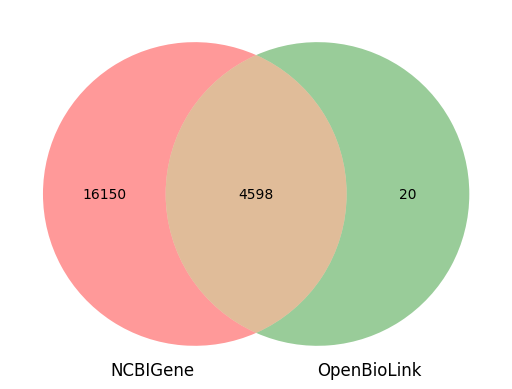

In [11]:
venn2_unweighted(
    [set(process_df['GeneID'].unique()), openbiolink_proteins],
    set_labels=['NCBIGene', 'OpenBioLink']
)

And let's investigate what the overlap is between the NCBI gene IDs in the GO and in the Custom KG:

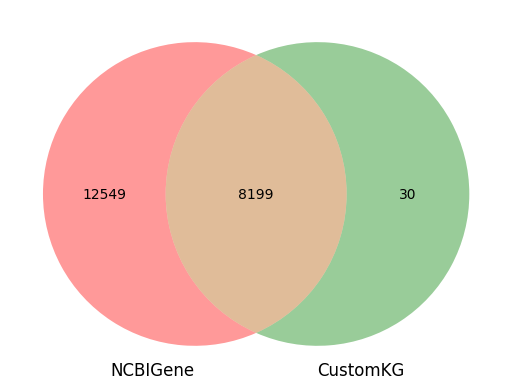

In [12]:
venn2_unweighted(
    [set(process_df['GeneID'].unique()), custom_proteins],
    set_labels=['NCBIGene', 'CustomKG']
)

# GO Annotations

Let's see what GO Annotations are connected to our proteins.

First, get all the proteins between the two KGs:

In [13]:
custom_proteins.update(openbiolink_proteins)
prots_of_interest = set(process_df['GeneID'].unique()).intersection(custom_proteins)
len(prots_of_interest)

9254

In [14]:
filtered_df = process_df[process_df['GeneID'].isin(prots_of_interest)]
filtered_df.to_csv('../data/mappings/in_kg_go_terms.tsv', sep='\t', index=False)

Remind our selves what's in the gene2GO dataframe:

In [15]:
process_df

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
812115,9606,ncbigene:1,GO:0003674,ND,enables,molecular_function,-,Function
812116,9606,ncbigene:1,GO:0005576,HDA,located_in,extracellular region,27068509,Component
812117,9606,ncbigene:1,GO:0005576,IDA,located_in,extracellular region,3458201,Component
812118,9606,ncbigene:1,GO:0005576,TAS,located_in,extracellular region,-,Component
812119,9606,ncbigene:1,GO:0005615,HDA,located_in,extracellular space,16502470,Component
...,...,...,...,...,...,...,...,...
1157942,9606,ncbigene:125316803,GO:0005615,IDA,located_in,extracellular space,32958672,Component
1157943,9606,ncbigene:125316803,GO:0005730,IDA,located_in,nucleolus,32958672,Component
1157944,9606,ncbigene:127138866,GO:0003674,ND,enables,molecular_function,-,Function
1157945,9606,ncbigene:127138866,GO:0008150,ND,involved_in,biological_process,-,Process


What's happening here? We are looping through the above dataframe and extracting the GO terms.

For each gene ID, we keep a set of associated GO terms.

We also separate the GO terms by BP, molecular function, and cellular component so that we can keep track of which type of GO term is associated with which gene.

In [16]:
genes = set()
function_keywords = {}
process_keywords = {}
component_keywords = {}

process_ids = set()

for tax_id, gene_id, go_id, ref, rel, term, pid, category  in tqdm(process_df.values):
    if category == 'Process':
        if gene_id not in process_keywords:
            process_keywords[gene_id] = set()
        process_keywords[gene_id].add(term)
        process_ids.add(go_id)
        genes.add(gene_id)

    if category == 'Function':
        if gene_id not in function_keywords:
            function_keywords[gene_id] = set()   
        function_keywords[gene_id].add(term)
        genes.add(gene_id)
    
    if category == 'Component':
        if gene_id not in component_keywords:
            component_keywords[gene_id] = set() 
        component_keywords[gene_id].add(term)
        genes.add(gene_id)
        
len(function_keywords), len(process_keywords), len(component_keywords), len(genes)

100%|██████████████████████████████| 345832/345832 [00:00<00:00, 1186501.79it/s]


(18495, 18903, 19866, 20748)

In [17]:
custom_proteins.update(openbiolink_proteins)

### Most Common GO Associations

What are the most common GO associations in our KG?

In [18]:
kg_nodes_with_process = 0
kg_nodes_with_function = 0
kg_nodes_with_comp = 0

kg_nodes_without = 0

number_of_process = []
number_of_compartments = []
number_of_functions = []

p_words = []
c_words = []
f_words = []

for node in tqdm(custom_proteins):
    
    if node not in genes:
        # these are not associated with any GO annotation
        kg_nodes_without += 1
    else:
        if node in process_keywords:
            kg_nodes_with_process += 1
            number_of_process.append(len(process_keywords[node]))
            
            # For the ones with multiple keywords, see what they are
            if len(process_keywords[node]) > 1:
                for keyword in process_keywords[node]:
                    p_words.append(keyword)

        if node in component_keywords:
            kg_nodes_with_comp += 1
            number_of_compartments.append(len(component_keywords[node]))

            # For the ones with multiple keywords, see what they are
            if len(component_keywords[node]) > 1:
                for keyword in component_keywords[node]:
                    c_words.append(keyword)

        if node in function_keywords:
            kg_nodes_with_function += 1
            number_of_functions.append(len(function_keywords[node]))
            # For the ones with multiple keywords, see what they are
            if len(function_keywords[node]) > 1:
                for keyword in function_keywords[node]:
                    f_words.append(keyword)

kg_nodes_without, kg_nodes_with_process, kg_nodes_with_comp, kg_nodes_with_function

100%|███████████████████████████████████| 9301/9301 [00:00<00:00, 330654.01it/s]


(47, 9142, 9195, 9122)

## Looking into most common terms

What are the most common cellular component terms?

In [19]:
Counter(c_words).most_common()

[('cytosol', 3379),
 ('nucleus', 2761),
 ('cytoplasm', 2670),
 ('plasma membrane', 2665),
 ('nucleoplasm', 2393),
 ('membrane', 1702),
 ('extracellular exosome', 1470),
 ('extracellular region', 1063),
 ('extracellular space', 1035),
 ('mitochondrion', 764),
 ('endoplasmic reticulum', 627),
 ('endoplasmic reticulum membrane', 585),
 ('Golgi apparatus', 579),
 ('chromatin', 563),
 ('intracellular membrane-bounded organelle', 539),
 ('nucleolus', 514),
 ('perinuclear region of cytoplasm', 476),
 ('cell surface', 469),
 ('protein-containing complex', 445),
 ('Golgi membrane', 390),
 ('focal adhesion', 319),
 ('synapse', 308),
 ('centrosome', 301),
 ('dendrite', 299),
 ('glutamatergic synapse', 294),
 ('external side of plasma membrane', 278),
 ('neuronal cell body', 272),
 ('neuron projection', 249),
 ('apical plasma membrane', 247),
 ('nuclear speck', 246),
 ('collagen-containing extracellular matrix', 245),
 ('endoplasmic reticulum lumen', 244),
 ('mitochondrial matrix', 234),
 ('mitoch

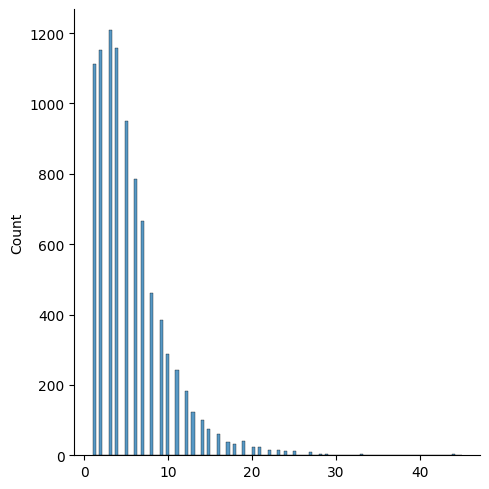

In [20]:
sns.displot(number_of_compartments)

What are the most common BP terms?

In [21]:
Counter(p_words).most_common()

[('signal transduction', 800),
 ('positive regulation of transcription by RNA polymerase II', 795),
 ('regulation of transcription by RNA polymerase II', 749),
 ('G protein-coupled receptor signaling pathway', 747),
 ('negative regulation of transcription by RNA polymerase II', 542),
 ('positive regulation of DNA-templated transcription', 484),
 ('detection of chemical stimulus involved in sensory perception of smell',
  404),
 ('regulation of DNA-templated transcription', 404),
 ('apoptotic process', 397),
 ('protein phosphorylation', 396),
 ('positive regulation of gene expression', 376),
 ('positive regulation of cell population proliferation', 371),
 ('negative regulation of apoptotic process', 354),
 ('inflammatory response', 336),
 ('negative regulation of DNA-templated transcription', 331),
 ('negative regulation of cell population proliferation', 318),
 ('cell differentiation', 285),
 ('innate immune response', 277),
 ('intracellular signal transduction', 261),
 ('cell adhesion

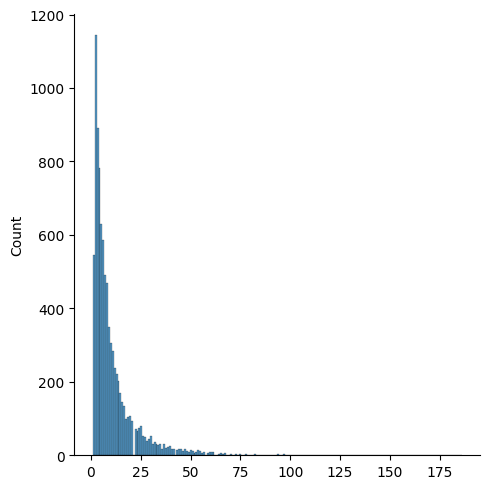

In [22]:
sns.displot(number_of_process)

What are the most molecular function terms?

In [23]:
Counter(f_words).most_common()

[('protein binding', 6350),
 ('metal ion binding', 1267),
 ('ATP binding', 1028),
 ('identical protein binding', 1018),
 ('RNA binding', 785),
 ('RNA polymerase II cis-regulatory region sequence-specific DNA binding',
  659),
 ('DNA-binding transcription factor activity, RNA polymerase II-specific',
  616),
 ('DNA binding', 575),
 ('G protein-coupled receptor activity', 553),
 ('protein homodimerization activity', 500),
 ('zinc ion binding', 418),
 ('olfactory receptor activity', 403),
 ('protein kinase binding', 343),
 ('calcium ion binding', 330),
 ('sequence-specific double-stranded DNA binding', 296),
 ('DNA-binding transcription activator activity, RNA polymerase II-specific',
  293),
 ('enzyme binding', 278),
 ('DNA-binding transcription factor activity', 271),
 ('chromatin binding', 266),
 ('protein-containing complex binding', 261),
 ('signaling receptor binding', 256),
 ('protein serine kinase activity', 249),
 ('ubiquitin protein ligase binding', 246),
 ('protein serine/threo

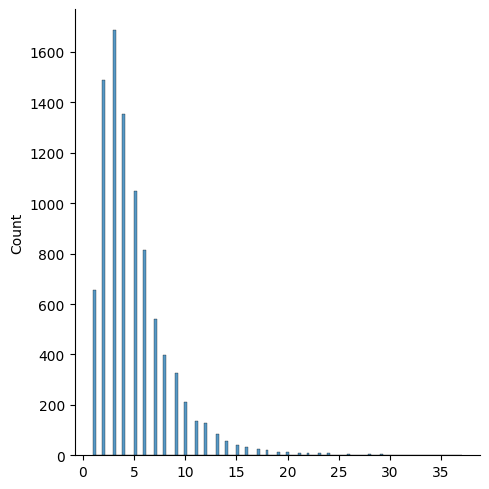

In [24]:
sns.displot(number_of_functions)

Since we're mostly interested in BPs, how many unique BPs are connected with proteins in our KG?

In [25]:
len(set(p_words))

11325

This is way too many. We'll have to find ways to filter them down.

## Drug-BP Labels

Next, we have drug-BP labels which were extracted from [ChEMBL](https://www.ebi.ac.uk/chembl/).

In [26]:
chembl_go = pd.read_csv(osp.join(MAPPING_DIR, "chembl_go.tsv"), sep="\t")

/var/folders/dz/hsmx5qv534b8zxlrfdjxfn9h0000gn/T/ipykernel_40629/2877799326.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  chembl_go = pd.read_csv(osp.join(MAPPING_DIR, "chembl_go.tsv"), sep="\t")


In [34]:
chembl_go.head(50)

,pref_name,chembl_idx,smiles,assay_id,pchembl_value,go_id,go_term
0,NaN,CHEMBL344142,C[C@]12CCC(=O)C=C1C(=O)CC1C2CC[C@@]2(C)C1CC[C@...,CHEMBL615157,NaN,GO:0000166,nucleotide binding
1,NaN,CHEMBL344142,C[C@]12CCC(=O)C=C1C(=O)CC1C2CC[C@@]2(C)C1CC[C@...,CHEMBL615157,NaN,GO:0016491,oxidoreductase activity
2,SPRIOLACTONE,CHEMBL400534,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[...,CHEMBL615157,NaN,GO:0000166,nucleotide binding
3,SPRIOLACTONE,CHEMBL400534,C[C@]12CCC(=O)C=C1CC[C@@H]1[C@@H]2CC[C@@]2(C)[...,CHEMBL615157,NaN,GO:0016491,oxidoreductase activity
4,NaN,CHEMBL3137945,C[C@]12CC[C@@]3(CCC(=O)O3)CC1CC[C@@H]1[C@@H]2C...,CHEMBL615157,NaN,GO:0000166,nucleotide binding
5,NaN,CHEMBL3137945,C[C@]12CC[C@@]3(CCC(=O)O3)CC1CC[C@@H]1[C@@H]2C...,CHEMBL615157,NaN,GO:0016491,oxidoreductase activity
6,NaN,CHEMBL1627632,C[C@]12CC[C@@H]3c4ccc(OCc5ccccc5)cc4CC[C@H]3[C...,CHEMBL615157,NaN,GO:0000166,nucleotide binding
7,NaN,CHEMBL1627632,C[C@]12CC[C@@H]3c4ccc(OCc5ccccc5)cc4CC[C@H]3[C...,CHEMBL615157,NaN,GO:0016491,oxidoreductase activity
8,NaN,CHEMBL139036,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)C2CC[C@@]3(C...,CHEMBL615157,NaN,GO:0000166,nucleotide binding
9,NaN,CHEMBL139036,CC(=O)S[C@@H]1CC2=CC(=O)CC[C@]2(C)C2CC[C@@]3(C...,CHEMBL615157,NaN,GO:0016491,oxidoreductase activity


How many interactions do we have?

In [28]:
len(chembl_go)

86268846

Unique drugs?

In [29]:
len(chembl_go['chembl_idx'].unique())

994690

Unique GO terms?

In [30]:
chembl_go_terms = set(chembl_go['go_id'])
len(chembl_go_terms)

267

How many of these GO terms overlap with the GO BPs we found before?

In [31]:
len(process_ids)

12527

In [32]:
bp_overlap = process_ids & chembl_go_terms
len(bp_overlap)

83

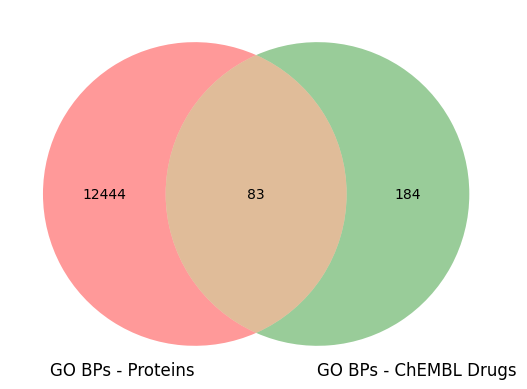

In [33]:
venn2_unweighted(
    [process_ids, chembl_go_terms],
    set_labels=['GO BPs - Proteins', 'GO BPs - ChEMBL Drugs']
)